In [18]:
import pandas as pd
import xml.etree.ElementTree as ET
import os
import numpy as np
from glob import glob

from PIL import Image, ImageDraw

Image.MAX_IMAGE_PIXELS = None
#from openslide import OpenSlide
from matplotlib import pyplot as plt
from ctypes.util import *
from ctypes import *

find_library("libopenslide-0.dll")
lib = cdll.LoadLibrary(find_library("libopenslide-0.dll"))

import openslide


In [19]:

src = r'\\fatherserverdw\kyuex\great'  #raw string of path
xmls = glob(os.path.join(src, '*xml'))

        Name Class ID  ID                                              Coord
0    corneum        1   1  [[[7833, 6594]], [[7833, 6593]], [[7833, 6592]...
1    corneum        1   2  [[[8596, 6019]], [[8597, 6019]], [[8597, 6018]...
2    corneum        1   3  [[[10214, 4918]], [[10215, 4918]], [[10215, 49...
3    corneum        1   4  [[[8993, 5313]], [[8992, 5313]], [[8991, 5313]...
4    corneum        1   5  [[[7521, 7007]], [[7521, 7006]], [[7521, 7004]...
..       ...      ...  ..                                                ...
144    white       12  17  [[[33402, 20590]], [[33404, 20590]], [[33405, ...
145    white       12  18  [[[39948, 39749]], [[39955, 39749]], [[39959, ...
146    white       12  19  [[[39193, 37963]], [[39189, 37963]], [[39185, ...
147    white       12  20  [[[39767, 38084]], [[39769, 38084]], [[39770, ...
148    white       12  21  [[[42828, 38263]], [[42828, 38262]], [[42829, ...

[149 rows x 4 columns]
        Name Class ID  ID                           

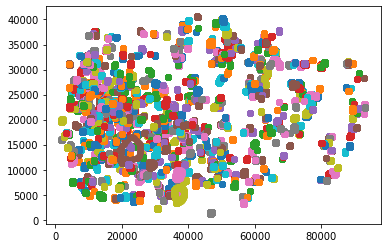

In [20]:
#pth = xmls[0]
for pth in xmls:

    tree = ET.parse(pth)
    root = tree.getroot()
    rows = []
    df_cols = ["Name", 'Class ID', "ID", 'Coord']
    for child in root:  #interate through the 12 classes
        class_id = child.attrib['Id']
        for Attrib in child.iter('Attribute'):
            name_str = Attrib.attrib['Name']
            # iterate each "circle"
            for region in child.iter('Region'):  #region in child
                #TODO:create numpy array of x,y
                temp_arr = []
                #initialize vertex
                vertex_arr = []
                idx = region.attrib['Id']  #idx for each region in attribute

                # collect XY coordinates into numpy list
                for coord in region.iter('Vertex'):  #vertex in each region
                    xy = np.array([[coord.attrib['X'], coord.attrib['Y']]])
                    vertex_arr.append(xy)

                py_vertex_arr = np.array(vertex_arr)

                #this is the numpy array of xy coordinates
                #append everything to rows
                rows.append({"Name": name_str, 'Class ID': class_id, "ID": idx,
                             "Coord": py_vertex_arr})

    out_df = pd.DataFrame(rows, columns=df_cols)
    # out_df.to_pickle(pth.replace('xml', 'pkl'))

    print(out_df)
    impth = pth.replace('xml', 'ndpi')
    imageobj = openslide.OpenSlide(impth)

    image_size = imageobj.dimensions
    (width, height) = image_size
    img = Image.new('L', (round(width), round(height)), 0)  #0 for default pixel value

    iter_order = [2, 10, 5, 4, 6, 11, 7, 9, 8, 12, 3, 1]

    for i in iter_order:
        for idx, row in out_df.iterrows():
            if (int(row['Class ID']) == i):
                color = i
                xycoord = np.squeeze((row['Coord'].astype('float64')).astype('uint32'))
                plt.scatter(xycoord[:, 0],
                            xycoord[:, 1])  #(x,y) this is right because (0,0) is the bottom left of the plot
                xycoord = list(zip(xycoord[:, 0], xycoord[:, 1]))  #turn [[,]] into tuples (x,y)
                #this fill value should be class id
                ImageDraw.Draw(img).polygon(xycoord, outline=None, fill=color)

    dstfn = pth.replace('xml', 'png')
    img.save(dstfn)

In [11]:


# read annotation
pkl_path = r'\\fatherserverdw\kyuex\great'
pkls = glob(os.path.join(pkl_path, '*pkl'))


for pkl in pkls:
    csvobj = pd.read_pickle(pkl)
    # read image size
    impth = pkl.replace('pkl', 'ndpi')
    #imageobj = OpenSlide(impth)
    imageobj = openslide.OpenSlide(impth)


    image_size = imageobj.dimensions
    (width, height) = image_size
    img = Image.new('L', (round(width), round(height)), 0)  #0 for default pixel value

    iter_order = [2, 10, 5, 4, 6, 11, 7, 9, 8, 12, 3, 1]


    for i in iter_order:
        for idx, row in csvobj.iterrows():
            if (int(row['Class ID']) == i):
                color = i
                xycoord = np.squeeze((row['Coord'].astype('float64')).astype('uint32'))
                plt.scatter(xycoord[:, 0],
                            xycoord[:, 1])  #(x,y) this is right because (0,0) is the bottom left of the plot
                xycoord = list(zip(xycoord[:, 0], xycoord[:, 1]))  #turn [[,]] into tuples (x,y)
                #this fill value should be class id
                ImageDraw.Draw(img).polygon(xycoord, outline=None, fill=color)

    dstfn = pkl.replace('pkl', 'png')
    img.save(dstfn)
